## Plot time series of SEA-POL low-level rain rate
From PICCOLO_level4b_rainrate_2D.nc

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap,Normalize
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
#import cmweather
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

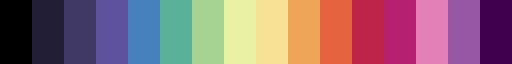

In [2]:
# Load colormap

# Read the colormap from a .txt file
def load_colormap_from_txt(file_path):
    # Load RGB values from the file
    rgb_values = np.loadtxt(file_path)
    return ListedColormap(rgb_values)

# Example usage
colormap_file = 'chase-spectral-rgb.txt'  # Replace with your .txt file path
radar_cmap = load_colormap_from_txt(colormap_file)

discrete_cmap = ListedColormap(radar_cmap(np.linspace(0, 1, 16)))
discrete_mask_cmap = discrete_cmap.copy()
discrete_mask_cmap.set_under(color='white') #set values below vmin to white
discrete_mask_cmap.set_bad(color='gray') #set missing (NaN) values to gray

discrete_mask_cmap

 Read in data

In [3]:
seapol = xr.open_dataset('../../data/SEA-POL_4b_rainrate_2D_spatial_means_masked.nc')
seapol

<xarray.Dataset> Size: 222kB
Dimensions:       (time: 4615)
Coordinates:
  * time          (time) datetime64[ns] 37kB 2024-08-16T08:10:00 ... 2024-09-...
Data variables:
    rain245_mean  (time) float32 18kB ...
    rain120_mean  (time) float32 18kB ...
    rain60_mean   (time) float32 18kB ...
    rain12_mean   (time) float32 18kB ...
    rain1_mean    (time) float32 18kB ...
    rain245_int   (time) float32 18kB ...
    rain120_int   (time) float32 18kB ...
    rain60_int    (time) float32 18kB ...
    rain12_int    (time) float32 18kB ...
    rain1_int     (time) float32 18kB ...
Attributes:
    title:        Spatial mean rainrate from SEA-POL long-range, low-elevatio...
    description:  Spatial means of rainrate from SEA-POL long-range, low-elev...
    source:       SEA-POL Level4b Gridded 2D Rain Rate
    units:        mm/h

Pad missing data with nans so it is on a regular 10-min time grid

In [100]:
# Make regular 10-minute time series
start_time = np.datetime64('2024-08-16T08:00:00')
end_time = np.datetime64('2024-09-23T16:50:00')
time10m = pd.date_range(start_time, end_time, freq='10 min')
time10m = pd.to_datetime(time10m)

# Make placeholder data array of nans of len(time10m)
rain245 = np.full(len(time10m), np.nan)
rain120 = np.full(len(time10m), np.nan)
rain60 = np.full(len(time10m), np.nan)
rain12 = np.full(len(time10m), np.nan)
rain1 = np.full(len(time10m), np.nan)

rain245int = np.full(len(time10m), np.nan)
rain120int = np.full(len(time10m), np.nan)
rain60int = np.full(len(time10m), np.nan)
rain12int = np.full(len(time10m), np.nan)
rain1int = np.full(len(time10m), np.nan)

# Convert both time arrays to pandas.DatetimeIndex for reliable comparison
seapol_times = pd.to_datetime(seapol.time.values)

# Find indices in time10m that are exactly in seapol.time
mask = np.isin(time10m, seapol_times)
matched_idx = np.where(mask)[0]

# Find corresponding indices in seapol.time for the matched times
seapol_idx = {t: i for i, t in enumerate(seapol_times)}
matched_seapol_idx = [seapol_idx[t] for t in time10m[mask]]

# Fill arrays only at matched indices
rain245[matched_idx]    = seapol.rain245_mean.values[matched_seapol_idx]
rain120[matched_idx]    = seapol.rain120_mean.values[matched_seapol_idx]
rain60[matched_idx]     = seapol.rain60_mean.values[matched_seapol_idx]
rain12[matched_idx]     = seapol.rain12_mean.values[matched_seapol_idx]
rain1[matched_idx]      = seapol.rain1_mean.values[matched_seapol_idx]

rain245int[matched_idx] = seapol.rain245_int.values[matched_seapol_idx]
rain120int[matched_idx] = seapol.rain120_int.values[matched_seapol_idx]
rain60int[matched_idx]  = seapol.rain60_int.values[matched_seapol_idx]
rain12int[matched_idx]  = seapol.rain12_int.values[matched_seapol_idx]
rain1int[matched_idx]   = seapol.rain1_int.values[matched_seapol_idx]

In [ ]:
seapol = xr.open_dataset('../../data/SEA-POL_4b_rainrate_2D_spatial_means_masked.nc')
rain245 = seapol.rain245_mean.values
rain120 = seapol.rain120_mean.values
rain60 = seapol.rain60_mean.values
rain12 = seapol.rain12_mean.values
rain1 = seapol.rain1_mean.values

rain245int = seapol.rain245_int.values
rain120int = seapol.rain120_int.values
rain60int = seapol.rain60_int.values
rain12int = seapol.rain12_int.values
rain1int = seapol.rain1_int.values

time10m = pd.to_datetime(seapol.time.values)

Plot area-mean precip & precip intensity time series

/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_56119/1414252246.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_56119/1414252246.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_56119/1414252246.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_56119/1414252246.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

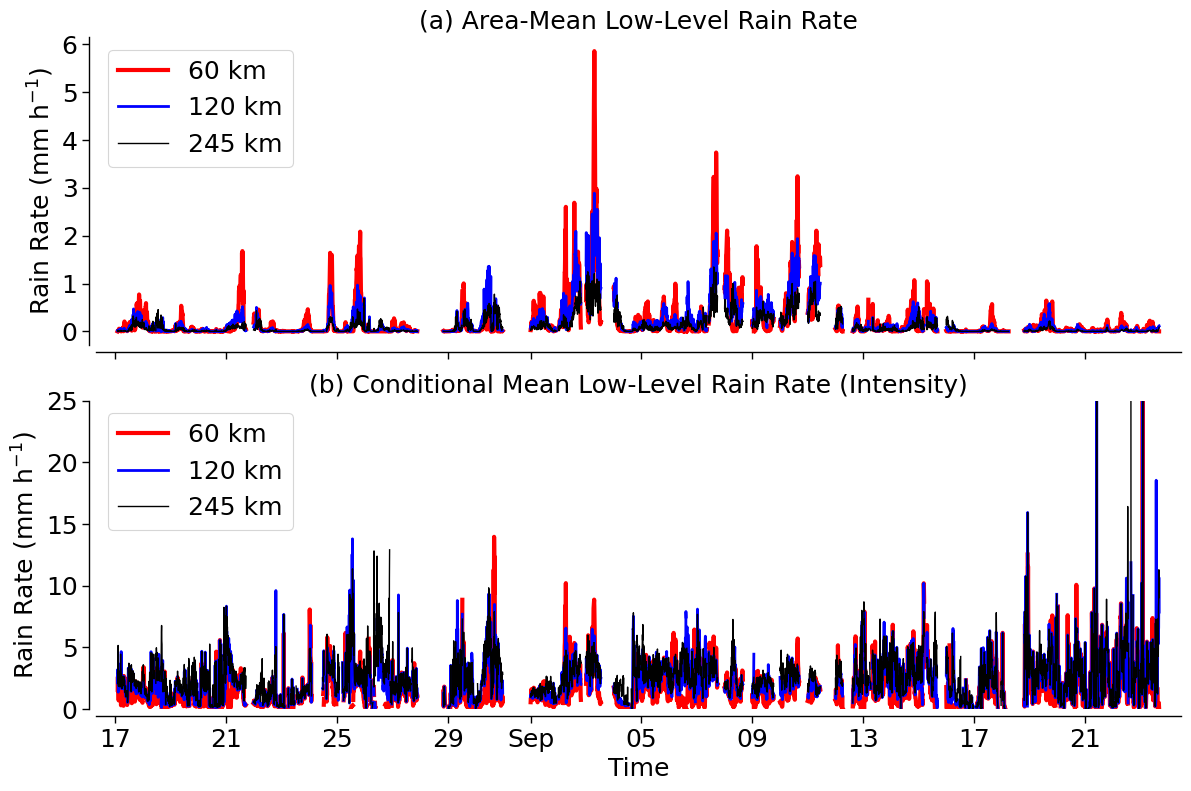

In [167]:
#Plot for whole campaign (10 minute data)

fig,axs = plt.subplots(2,1,figsize=(12,8),layout="constrained")

axs[0].plot(time10m, rain60, color='red', label='60 km', linewidth=3)
axs[0].plot(time10m, rain120, color='blue', label='120 km', linewidth=2)
axs[0].plot(time10m, rain245, color='black', label='245 km', linewidth=1)
axs[0].set_title('(a) Area-Mean Low-Level Rain Rate',fontsize=18)
axs[0].set_ylabel('Rain Rate (mm h$^{-1}$)', fontsize=18)
#axs[0].set_xlabel('Time',fontsize=18)

sns.set_context('paper') 
sns.despine(offset=5)

axs[0].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

axs[0].legend(loc='upper left', fontsize=18)
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

axs[0].set_xticklabels([])
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)

axs[1].plot(time10m, rain60int, color='red', label='60 km', linewidth=3)
axs[1].plot(time10m, rain120int, color='blue', label='120 km', linewidth=2)
axs[1].plot(time10m, rain245int, color='black', label='245 km', linewidth=1)
axs[1].set_title('(b) Conditional Mean Low-Level Rain Rate (Intensity)',fontsize=18)
axs[1].set_ylabel('Rain Rate (mm h$^{-1}$)', fontsize=18)
axs[1].set_xlabel('Time',fontsize=18)

axs[1].set_ylim(0,25)
axs[1].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

axs[1].legend(loc='upper left', fontsize=18)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[1].xaxis.get_major_locator()))

axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=18)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)

plt.tight_layout() 

In [102]:
#Find where intensity greater than 25
rain245int_gt25 = np.where(rain245int > 25)[0]
print('rain245int > 25:',rain245int[rain245int_gt25])

rain120int_gt25 = np.where(rain120int > 25)[0]
print('rain120int > 25:',rain120int[rain120int_gt25])

rain60int_gt25 = np.where(rain60int > 25)[0]
print('rain60int > 25:',rain60int[rain60int_gt25])

rain245int > 25: [38.08486557 59.2149086  45.22286224]
rain120int > 25: [38.08486557 45.22286224]
rain60int > 25: [45.22286224]


Coarsen SEA-POL data to hourly (block average)

In [103]:
#convert to xarray dataarray
rain245_da = xr.DataArray(rain245, coords=[time10m], dims=['time'], name='rain245')
rain120_da = xr.DataArray(rain120, coords=[time10m], dims=['time'], name='rain120')
rain60_da = xr.DataArray(rain60, coords=[time10m], dims=['time'], name='rain60')
rain12_da = xr.DataArray(rain12, coords=[time10m], dims=['time'], name='rain12')
rain1_da = xr.DataArray(rain1, coords=[time10m], dims=['time'], name='rain1')

rain245int_da = xr.DataArray(rain245int, coords=[time10m], dims=['time'], name='rain245int')
rain120int_da = xr.DataArray(rain120int, coords=[time10m], dims=['time'], name='rain120int')
rain60int_da = xr.DataArray(rain60int, coords=[time10m], dims=['time'], name='rain60int')
rain12int_da = xr.DataArray(rain12int, coords=[time10m], dims=['time'], name='rain12int')
rain1int_da = xr.DataArray(rain1int, coords=[time10m], dims=['time'], name='rain1int')

In [123]:
rain245_hrly = rain245_da.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true') #6 10-minute intervals = 1 hour
rain120_hrly = rain120_da.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')
rain60_hrly = rain60_da.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')
rain12_hrly = rain12_da.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')
rain1_hrly = rain1_da.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')

rain245int_hrly = rain245int_da.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')
rain120int_hrly = rain120int_da.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')
rain60int_hrly = rain60int_da.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')
rain12int_hrly = rain12int_da.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')
rain1int_hrly = rain1int_da.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')    

Read in IMERG and ERA_5 along track data. 

IMERG has been interpolated to a 0.25 degree grid and coarsened to hourly resolution. 

In [ ]:
alongtrack = xr.open_dataset('../../data/IWVprecip_alongtrack.nc')
#precip_alongtrack_imerg
#precip_alongtrack_era5

Plot

/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_56119/3816676389.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_56119/3816676389.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_56119/3816676389.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_56119/3816676389.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


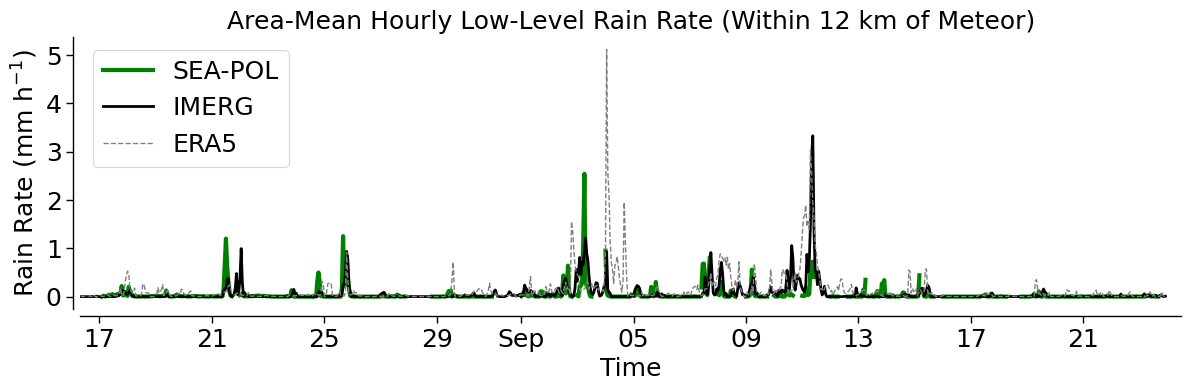

In [166]:
#Plot for whole campaign (hourly data)

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")

ax.plot(rain12_hrly.time, rain12_hrly, color='green', label='SEA-POL', linewidth=3)
ax.plot(alongtrack.time, alongtrack.precip_alongtrack_imerg, color='black', label='IMERG', linewidth=2)
ax.plot(alongtrack.time, alongtrack.precip_alongtrack_era5, color='gray', label='ERA5', linewidth=1, linestyle = '--')

sns.set_context('paper') 
sns.despine(offset=5)

ax.set_title('Area-Mean Hourly Low-Level Rain Rate (Within 12 km of Meteor)',fontsize=18)
ax.set_ylabel('Rain Rate (mm h$^{-1}$)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

ax.legend(loc='upper left', fontsize=18)
ax.set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

plt.tight_layout() 


/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_56119/142212114.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_56119/142212114.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_56119/142212114.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_56119/142212114.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_t

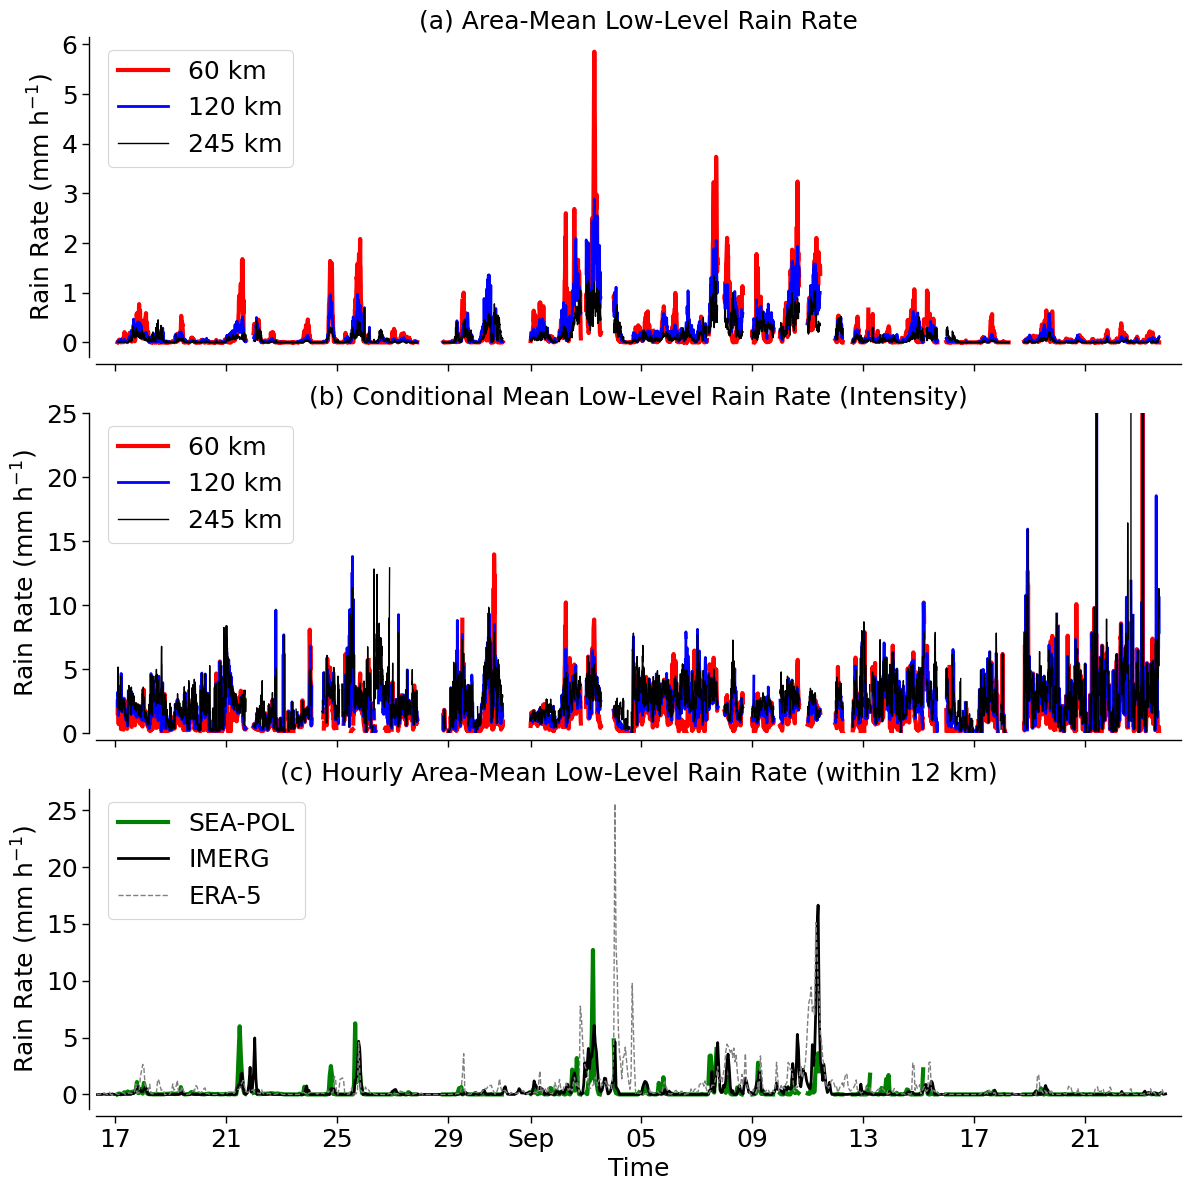

In [208]:
#Plot for whole campaign (10 minute data)

fig,axs = plt.subplots(3,1,figsize=(12,12),layout="constrained")

axs[0].plot(time10m, rain60, color='red', label='60 km', linewidth=3)
axs[0].plot(time10m, rain120, color='blue', label='120 km', linewidth=2)
axs[0].plot(time10m, rain245, color='black', label='245 km', linewidth=1)
axs[0].set_title('(a) Area-Mean Low-Level Rain Rate',fontsize=18)
axs[0].set_ylabel('Rain Rate (mm h$^{-1}$)', fontsize=18)
#axs[0].set_xlabel('Time',fontsize=18)

sns.set_context('paper') 
sns.despine(offset=5)

axs[0].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

axs[0].legend(loc='upper left', fontsize=18)
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

axs[0].set_xticklabels([])
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)

axs[1].plot(time10m, rain60int, color='red', label='60 km', linewidth=3)
axs[1].plot(time10m, rain120int, color='blue', label='120 km', linewidth=2)
axs[1].plot(time10m, rain245int, color='black', label='245 km', linewidth=1)
axs[1].set_title('(b) Conditional Mean Low-Level Rain Rate (Intensity)',fontsize=18)
axs[1].set_ylabel('Rain Rate (mm h$^{-1}$)', fontsize=18)
#axs[1].set_xlabel('Time',fontsize=18)

axs[1].set_ylim(0,25)
axs[1].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

axs[1].legend(loc='upper left', fontsize=18)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[1].xaxis.get_major_locator()))

axs[1].set_xticklabels([])
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)

axs[2].plot(rain12_hrly.time, rain12_hrly, color='green', label='SEA-POL', linewidth=3)
axs[2].plot(alongtrack.time, alongtrack.precip_alongtrack_imerg, color='black', label='IMERG', linewidth=2)
axs[2].plot(alongtrack.time, alongtrack.precip_alongtrack_era5, color='gray', label='ERA-5', linewidth=1, linestyle = '--')

axs[2].set_title('(c) Hourly Area-Mean Low-Level Rain Rate (within 12 km)',fontsize=18)
axs[2].set_ylabel('Rain Rate (mm h$^{-1}$)', fontsize=18)
axs[2].set_xlabel('Time',fontsize=18)

axs[2].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

axs[2].legend(loc='upper left', fontsize=18)
axs[2].set_yticklabels(axs[2].get_yticklabels(), fontsize=18)
axs[2].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[2].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[2].xaxis.get_major_locator()))

axs[2].set_xticklabels(axs[2].get_xticklabels(), fontsize=18)
axs[2].set_yticklabels(axs[2].get_yticklabels(), fontsize=18)

plt.tight_layout() 

plt.savefig('../../figures/SEAPOL/Fig_precip_timeseries.png')

In [ ]:
#find where alongtrack.time is rain12_hrly.time[-1]
rain12_hrly_time = pd.to_datetime(rain12_hrly.time.values)
last_time = rain12_hrly_time[-1]
alongtrack_time = pd.to_datetime(alongtrack.time.values)
last_alongtrack_idx = np.where(alongtrack_time == last_time)[0][0]

Timestamp('2024-09-23 16:00:00')

/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_56119/1465051337.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_56119/1465051337.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_56119/1465051337.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


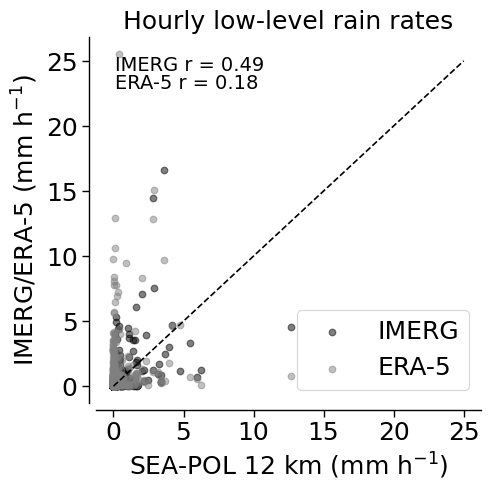

In [165]:
# Scatter plot of imerg and era-5 against rain12_hrly
fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")
ax.scatter(rain12_hrly,alongtrack.precip_alongtrack_imerg[0:last_alongtrack_idx+1], color='black', label='IMERG', alpha=0.5)
ax.scatter(rain12_hrly,alongtrack.precip_alongtrack_era5[0:last_alongtrack_idx+1], color='gray', label='ERA-5', alpha=0.5)

#plot 1:1 line
x = np.linspace(0, 25, 100)
ax.plot(x, x, color='black', linestyle='--')

#calculate correlation coefficient, ignoring nans
corr_imerg = np.corrcoef(rain12_hrly[~np.isnan(rain12_hrly)], alongtrack.precip_alongtrack_imerg[0:last_alongtrack_idx+1][~np.isnan(rain12_hrly)])[0, 1]
corr_era5 = np.corrcoef(rain12_hrly[~np.isnan(rain12_hrly)], alongtrack.precip_alongtrack_era5[0:last_alongtrack_idx+1][~np.isnan(rain12_hrly)])[0, 1]
ax.text(0.05, 0.95, f'IMERG r = {corr_imerg:.2f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')
ax.text(0.05, 0.90, f'ERA-5 r = {corr_era5:.2f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')

sns.set_context('paper') 
sns.despine(offset=5)

ax.set_ylabel('IMERG/ERA-5 (mm h$^{-1}$)', fontsize=18)
ax.set_xlabel('SEA-POL 12 km (mm h$^{-1}$)', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_title('Hourly low-level rain rates', fontsize=18)
ax.legend(fontsize=18)

plt.tight_layout() 

SEA-POL hourly running mean

In [182]:
# SEA-POL hourly running mean
rain12_hrly_run = rain12_da.rolling(time=6, center=True).mean() # 6*10=60 minute running mean

/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_56119/3084418550.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


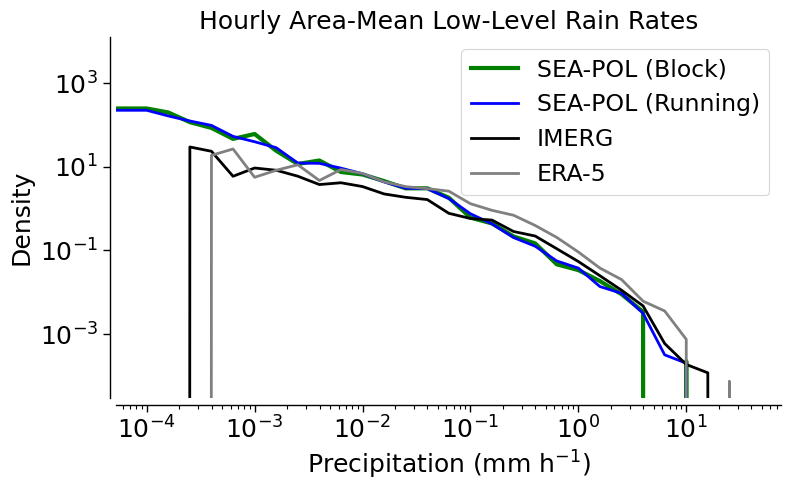

In [209]:
fig,ax = plt.subplots(figsize=(8,5),layout="constrained")

pbins = np.concatenate(([0],np.power(10,np.arange(-4,2,0.2))))

## SEA-POL 12 km
phist_seapol12, bin_edges = np.histogram(rain12_hrly, bins=pbins, density=True)
phist_seapol12_run, bin_edges = np.histogram(rain12_hrly_run, bins=pbins, density=True)
phist_imerg, bin_edges = np.histogram(alongtrack.precip_alongtrack_imerg[0:last_alongtrack_idx+1], bins=pbins, density=True)
phist_era5, bin_edges = np.histogram(alongtrack.precip_alongtrack_era5[0:last_alongtrack_idx+1], bins=pbins, density=True)

ax.plot(bin_edges[:-1], phist_seapol12, color='green', label='SEA-POL (Block)', linewidth=3)
ax.plot(bin_edges[:-1], phist_seapol12_run, color='blue', label='SEA-POL (Running)', linewidth=2)
ax.plot(bin_edges[:-1], phist_imerg, color='black', label='IMERG',linewidth=2)
ax.plot(bin_edges[:-1], phist_era5, color='gray', label='ERA-5',linewidth=2)

ax.set_title('Hourly Area-Mean Low-Level Rain Rates',fontsize=18)
ax.set_xlabel('Precipitation (mm h$^{-1}$)',fontsize=18)
ax.set_ylabel('Density',fontsize=18)
#ax.set_xlim(0,25)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=17, loc='upper right')
ax.tick_params(labelsize=18)

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout() 

plt.savefig('../../figures/SEAPOL/Fig_SEAPOL_IMERG_ERA5_pdf.png')